# Matrix Factorization Models
**Objective:** Implement and evaluate latent factor models to address data sparsity

Models:
1.  FunkSVD - rains on explicit user ratings by minimizing prediction error (measured with RMSE)
2.  ALS - uses alternating least-squares updates for fast, stable training on large datasets

We use the same time-based split and metrics (NDCG, Recall, Coverage) as defined in the Evaluation Framework

In [1]:
import os
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
import joblib
warnings.filterwarnings('ignore')

PROCESSED_DIR = "../data/processed"

train = pd.read_csv(os.path.join(PROCESSED_DIR, "train.csv"))
val = pd.read_csv(os.path.join(PROCESSED_DIR, "val.csv"))
test = pd.read_csv(os.path.join(PROCESSED_DIR, "test.csv"))

n_users = train['user_id'].max() + 1
n_items = train['item_id'].max() + 1

In [2]:
def dcg_at_k(relevance_scores, k):
    relevance_scores = np.array(relevance_scores)[:k]
    if relevance_scores.size == 0:
        return 0.0
    gains = 2 ** relevance_scores - 1
    discounts = np.log2(np.arange(2, relevance_scores.size + 2))
    return np.sum(gains / discounts)

def ndcg_at_k(predictions, ground_truth, k=10):
    if not predictions or not ground_truth:
        return 0.0
    
    relevance = [ground_truth.get(item_id, 0) for item_id, _ in predictions[:k]]
    
    ideal_relevance = sorted(ground_truth.values(), reverse=True)
    
    dcg = dcg_at_k(relevance, k)
    idcg = dcg_at_k(ideal_relevance, k)
    
    return dcg / idcg if idcg > 0 else 0.0

def recall_at_k(predictions, ground_truth, k=10, threshold=4.0):
    if not predictions or not ground_truth:
        return 0.0
    
    relevant_items = {item for item, rating in ground_truth.items() if rating >= threshold}
    
    if len(relevant_items) == 0:
        return 0.0
    
    predicted_items = {item_id for item_id, _ in predictions[:k]}
    
    hits = len(predicted_items & relevant_items)
    return hits / len(relevant_items)

def precision_at_k(predictions, ground_truth, k=10, threshold=4.0):
    if not predictions or not ground_truth:
        return 0.0
    
    relevant_items = {item for item, rating in ground_truth.items() if rating >= threshold}
    predicted_items = {item_id for item_id, _ in predictions[:k]}
    
    if len(predicted_items) == 0:
        return 0.0
    
    hits = len(predicted_items & relevant_items)
    return hits / len(predicted_items)

def coverage(all_predictions, item_catalog):
    recommended_items = set()
    for preds in all_predictions:
        recommended_items.update([item_id for item_id, _ in preds])
    
    return len(recommended_items) / len(item_catalog) if len(item_catalog) > 0 else 0.0

def popularity_bias(all_predictions, item_popularity):
    all_recommended = []
    for preds in all_predictions:
        all_recommended.extend([item_id for item_id, _ in preds])
    
    if not all_recommended:
        return 0.0
    
    avg_pop = np.mean([item_popularity.get(item, 0) for item in all_recommended])
    return avg_pop

class RecommenderEvaluator:    
    def __init__(self, train_df, test_df, k_values=[5, 10, 20], relevance_threshold=4.0):
        self.train_df = train_df
        self.test_df = test_df
        self.k_values = k_values
        self.relevance_threshold = relevance_threshold
        
        self.ground_truth = self.build_ground_truth()
        
        self.item_catalog = set(train_df['item_id'].unique())
        self.item_popularity = train_df.groupby('item_id').size().to_dict()

        self.history = []
        
    def build_ground_truth(self):
        ground_truth = defaultdict(dict)
        for _, row in self.test_df.iterrows():
            ground_truth[row['user_id']][row['item_id']] = row['rating']
        return dict(ground_truth)
    
    def evaluate_model(self, model, model_name="Model"):
        results = defaultdict(list)
        all_predictions = []
        
        test_users = list(self.ground_truth.keys())
        
        for user_id in test_users:
            gt = self.ground_truth[user_id]
            
            max_k = max(self.k_values)
            predictions = model.predict_for_user(user_id, k=max_k, train_df=self.train_df)
            all_predictions.append(predictions)
            
            for k in self.k_values:
                results[f'NDCG@{k}'].append(ndcg_at_k(predictions, gt, k))
                results[f'Recall@{k}'].append(recall_at_k(predictions, gt, k, self.relevance_threshold))
                results[f'Precision@{k}'].append(precision_at_k(predictions, gt, k, self.relevance_threshold))
        
        metrics = {}
        for metric_name, values in results.items():
            metrics[metric_name] = np.mean(values)
        
        metrics['Coverage'] = coverage(all_predictions, self.item_catalog)
        metrics['Popularity_Bias'] = popularity_bias(all_predictions, self.item_popularity)
        metrics['Model'] = model_name
        self.history.append(metrics)
        
        return metrics
    
    def print_metrics(self, metrics, model_name="Model"):
        print(f"{model_name} - Evaluation results")
        
        print("Ranking metrics:")
        for k in self.k_values:
            print(f"NDCG@{k:2d}: {metrics[f'NDCG@{k}']:.4f}")
        
        print("\n")
        
        print("Relevance metrics (threshold={:.1f}):".format(self.relevance_threshold))
        for k in self.k_values:
            print(f"Recall@{k:2d}: {metrics[f'Recall@{k}']:.4f}")
            print(f"Precision@{k:2d}: {metrics[f'Precision@{k}']:.4f}")
        
        print("\n")
        
        print(f"Diversity metrics:")
        print(f"Coverage: {metrics['Coverage']:.4f}")
        print(f"Popularity bias: {metrics['Popularity_Bias']:.2f}")

    def save_results(self, filepath):
        if not self.history:
            print("No history to save")
            return

        df = pd.DataFrame(self.history)
        
        cols = ['Model'] + [c for c in df.columns if c != 'Model']
        df = df[cols]
        
        df.to_csv(filepath, index=False)

evaluator_val = RecommenderEvaluator(train, val, k_values=[5, 10, 20])
evaluator_test = RecommenderEvaluator(train, test, k_values=[5, 10, 20])

## 1. FunkSVD Implementation
* Method: Stochastic Gradient Descent
* Minimizes the squared error between predicted and actual ratings
* Numba is used to compile the inner training loop for better performance

**Theoretical Basis:**
FunkSVD decomposes the interaction matrix $R$ into two lower-rank matrices: User Factors ($P$) and Item Factors ($Q$). The prediction for user $u$ and item $i$ is calculated as:

$$\hat{r}_{ui} = \mu + b_u + b_i + P_u \cdot Q_i$$

Where:
* $\mu$: Global average rating.
* $b_u, b_i$: User and Item biases (baseline deviations).
* $P_u, Q_i$: Latent feature vectors.

Optimization Strategy (SGD):
We iterate through every observed rating in the training set and perform a gradient descent update:
1.  Calculate Error: $e_{ui} = r_{ui} - \hat{r}_{ui}$
2.  Update Parameters: Move $P_u$ and $Q_i$ in the opposite direction of the gradient to minimize squared error (plus regularization).

In [3]:
from numba import njit, prange

# compiling function for higher performance
@njit(parallel=True, fastmath=True)
def funksvd_epoch(users, items, ratings, user_factors, item_factors, user_bias, item_bias, global_bias, lr, reg):

    n = len(users)
    # shuffling indices to perform SGD (random sampling) to prevent model from learning patterns based on order of data
    indices = np.random.permutation(n)
    loss = 0.0
    
    # loop over every interaction in the dataset
    for i in prange(n):
        idx = indices[i]
        u, it, r = users[idx], items[idx], ratings[idx]
        
        # forward pass - predicting rating
        # r_hat = mu + b_u + b_i + (P_u . Q_i)
        pred = global_bias + user_bias[u] + item_bias[it] + np.dot(user_factors[u], item_factors[it])
        
        # calculate error
        err = r - pred
        loss += err * err
        
        # backward pass - update biases
        # b_new = b_old + lr * (error - reg * b_old)
        user_bias[u] += lr * (err - reg * user_bias[u])
        item_bias[it] += lr * (err - reg * item_bias[it])
        
        # update latent factors. perform coordinate descent step
        uf_old = user_factors[u].copy()

        # P_u += lr * (error * Q_i - reg * P_u)
        user_factors[u] += lr * (err * item_factors[it] - reg * user_factors[u])
        # Q_i += lr * (error * P_u_old - reg * Q_i)
        item_factors[it] += lr * (err * uf_old - reg * item_factors[it])
    
    # Return RMSE for this epoch to track convergence
    return np.sqrt(loss / n)


class FunkSVD:
    def __init__(self, n_factors=50, learning_rate=0.005, regularization=0.02, n_epochs=20, verbose=True):

        # hyperparameters
        self.n_factors = n_factors # num of latent vectors
        self.lr = learning_rate # step size for SGD
        self.reg = regularization # L2 penalty

        self.n_epochs = n_epochs
        self.verbose = verbose

        # model weights
        self.user_factors = None # Matrix P (n_users x k)
        self.item_factors = None # Matrix Q (n_items x k)
        self.user_bias = None # Vector b_u
        self.item_bias = None # Vector b_i
        self.global_bias = None # Scalar mu

        # for metrics
        self.train_loss_history = []
        self.val_loss_history = []

    def fit(self, train_df, val_df=None): # training factorization model 

        # matrix shape
        n_users = train_df['user_id'].max() + 1
        n_items = train_df['item_id'].max() + 1

        np.random.seed(42)
        
        # initialize latent factors using normal distribution. Not zero as in this case gradients would be also zero
        self.user_factors = np.random.normal(0, 0.1, (n_users, self.n_factors))
        self.item_factors = np.random.normal(0, 0.1, (n_items, self.n_factors))

        # biases set to zero
        self.user_bias, self.item_bias = np.zeros(n_users), np.zeros(n_items)
        # global bias is just the average rating of the training set
        self.global_bias = train_df['rating'].mean()
        
        # data prep for numba
        users = train_df['user_id'].values.astype(np.int32)
        items = train_df['item_id'].values.astype(np.int32)
        ratings = train_df['rating'].values.astype(np.float64)
        
        # training loop
        for epoch in range(self.n_epochs):
            train_rmse = funksvd_epoch(users, items, ratings, self.user_factors, 
                                       self.item_factors, self.user_bias, self.item_bias,
                                       self.global_bias, self.lr, self.reg)
            self.train_loss_history.append(train_rmse)
            
            # validation
            if val_df is not None:
                val_rmse = self.compute_rmse(val_df)
                self.val_loss_history.append(val_rmse)
                if self.verbose and epoch % 5 == 0:
                    print(f"epoch {epoch:2d}: train={train_rmse:.4f}, val={val_rmse:.4f}")
    

    def compute_rmse(self, df): # RMSE calculation 
        u = df['user_id'].values
        i = df['item_id'].values
        r = df['rating'].values

        # Global + User Bias + Item Bias + Dot Product
        pred = self.global_bias + self.user_bias[u] + self.item_bias[i] + np.sum(self.user_factors[u] * self.item_factors[i], axis=1)

        # clip predictions to valid range [1, 5] before calculating error
        return np.sqrt(np.mean((r - np.clip(pred, 1, 5)) ** 2))
    
    def predict_rating(self, user_id, item_id): # predict single rating 

        # cold start check. if user or item not present in training, return global average
        if user_id >= len(self.user_factors) or item_id >= len(self.item_factors):
            return self.global_bias
        
        # matrix factorization formula
        pred = self.global_bias + self.user_bias[user_id] + self.item_bias[item_id] + np.dot(self.user_factors[user_id], self.item_factors[item_id])
        
        return np.clip(pred, 1.0, 5.0)
    
    # generating top-K recommendations for a user
    def predict_for_user(self, user_id, k=10, train_df=None):

        # empty if unknown
        if user_id >= len(self.user_factors):
            return []
        
        # identify items the user has already rated to exclude them later
        rated = set(train_df[train_df['user_id'] == user_id]['item_id']) if train_df is not None else set()

        # scoring 
        scores = self.global_bias + self.user_bias[user_id] + self.item_bias + self.item_factors @ self.user_factors[user_id]

        # masking 
        # set scores of already watched movies to -infinity so they aren't recommended
        scores[list(rated)] = -np.inf

        # top K retrieval
        top_k = np.argpartition(scores, -k)[-k:]
        top_k = top_k[np.argsort(scores[top_k])[::-1]]

        return [(i, scores[i]) for i in top_k]

In [4]:
# hyperparameter tuning
factor_values = [10, 20, 30, 40, 50, 60]
funksvd_factor_results = []

for n_factors in factor_values:
    print(f"FunkSVD with {n_factors} factors")
    model = FunkSVD(n_factors=n_factors, learning_rate=0.005, regularization=0.02, n_epochs=15, verbose=True)
    model.fit(train, val)
    
    print(f"final train RMSE: {model.train_loss_history[-1]:.4f}")
    print(f"final val RMSE: {model.val_loss_history[-1]:.4f}")
    
    metrics = evaluator_val.evaluate_model(model, f"FunkSVD-{n_factors}")
    
    funksvd_factor_results.append({
        'factors': n_factors,
        'train_rmse': model.train_loss_history[-1],
        'val_rmse': model.val_loss_history[-1],
        'NDCG@10': metrics['NDCG@10'],
        'Recall@10': metrics['Recall@10']
    })

FunkSVD with 10 factors
epoch  0: train=0.9803, val=0.9503
epoch  5: train=0.9008, val=0.9148
epoch 10: train=0.8843, val=0.9049
final train RMSE: 0.8603
final val RMSE: 0.8915
FunkSVD with 20 factors
epoch  0: train=0.9810, val=0.9515
epoch  5: train=0.8976, val=0.9148
epoch 10: train=0.8722, val=0.9012
final train RMSE: 0.8421
final val RMSE: 0.8874
FunkSVD with 30 factors
epoch  0: train=0.9814, val=0.9512
epoch  5: train=0.8943, val=0.9144
epoch 10: train=0.8616, val=0.8982
final train RMSE: 0.8268
final val RMSE: 0.8852
FunkSVD with 40 factors
epoch  0: train=0.9819, val=0.9515
epoch  5: train=0.8912, val=0.9141
epoch 10: train=0.8537, val=0.8975
final train RMSE: 0.8149
final val RMSE: 0.8850
FunkSVD with 50 factors
epoch  0: train=0.9822, val=0.9516
epoch  5: train=0.8878, val=0.9138
epoch 10: train=0.8444, val=0.8959
final train RMSE: 0.8019
final val RMSE: 0.8841
FunkSVD with 60 factors
epoch  0: train=0.9825, val=0.9522
epoch  5: train=0.8836, val=0.9128
epoch 10: train=0.834

In [5]:
factor_df = pd.DataFrame(funksvd_factor_results)
print(factor_df.to_string(index=False))

 factors  train_rmse  val_rmse  NDCG@10  Recall@10
      10    0.860347  0.891531 0.020855   0.018738
      20    0.842110  0.887433 0.024059   0.022553
      30    0.826839  0.885247 0.025736   0.021965
      40    0.814875  0.884953 0.024660   0.022276
      50    0.801911  0.884095 0.024356   0.021487
      60    0.789423  0.882795 0.027449   0.024179


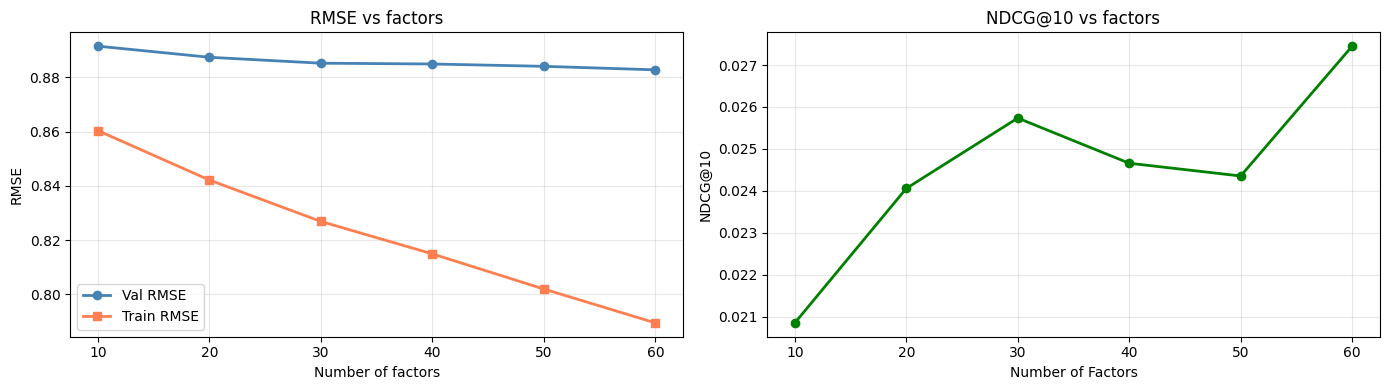

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(factor_df['factors'], factor_df['val_rmse'], marker='o', linewidth=2, color='steelblue', label='Val RMSE')
axes[0].plot(factor_df['factors'], factor_df['train_rmse'], marker='s', linewidth=2, color='coral', label='Train RMSE')
axes[0].set_xlabel('Number of factors')
axes[0].set_ylabel('RMSE')
axes[0].set_title('RMSE vs factors')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(factor_df['factors'], factor_df['NDCG@10'], marker='o', linewidth=2, color='green')
axes[1].set_xlabel('Number of Factors')
axes[1].set_ylabel('NDCG@10')
axes[1].set_title('NDCG@10 vs factors')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../experiments/figures/05_funksvd_plot_curves.png')
plt.show()

### Tuning results
* Optimal amount of factors is 30, where NDCG@10 peaks. Increasing factors to 60 actually hurts performance. From loss curve we can clearly observe overfitting, where train RMSE drops rapidly and validaiton RMSE stays relatively the same and metrics drop

## 2. Alternating Least Squares (ALS)
* Strategy Fix User vectors to solve Item vectors. Fix Item vectors to solve User vectors
* Good for parallelization; often more stable than SGD
* Higher memory usage for matrix inversion

Theoretical Basis:
Unlike SGD, which updates parameters iteratively for every single rating, ALS utilizes a "coordinate descent" approach. It works on the principle that if we fix the User Factors ($P$), the optimal solution for the Item Factors ($Q$) becomes a simple quadratic problem (Least Squares) with a closed-form solution.

We alternate between two steps:
1.  Fix Users, Solve Items: $Q_i = (P^T P + \lambda I)^{-1} P^T (R_i - \mu)$
2.  Fix Items, Solve Users: $P_u = (Q^T Q + \lambda I)^{-1} Q^T (R_u - \mu)$


In [7]:
class ALS:
    def __init__(self, n_factors=20, regularization=0.1, n_iterations=15, verbose=True):

        # hyperparameters
        self.n_factors = n_factors # latent dimension (k)
        self.reg = regularization # L2 regularization (lambda)
        self.n_iterations = n_iterations
        self.verbose = verbose
        
        # params to learn
        self.user_factors = None # Matrix P (n_users x k)
        self.item_factors = None # Matrix Q (n_items x k)
        self.global_mean = 0 # Mu

        # for metrics
        self.train_loss_history = []
        self.val_loss_history = []
    
    def fit(self, train_df, val_df=None): # training ALS 
        n_users = train_df['user_id'].max() + 1
        n_items = train_df['item_id'].max() + 1
        
        # center ratings - deviations from the mean
        # r_ui = mu + P_u . Q_i  -->  (r_ui - mu) = P_u . Q_i
        self.global_mean = train_df['rating'].mean()
        centered_ratings = train_df['rating'].values - self.global_mean
        
        rows = train_df['user_id'].values
        cols = train_df['item_id'].values
        
        # sparse matrix construction

        # R - all items rated by user u
        R = csr_matrix((centered_ratings, (rows, cols)), shape=(n_users, n_items))
        # R_T - all users who rated item i
        R_T = R.T.tocsr()
        
        np.random.seed(42)

        # initialize factors with random noise
        self.user_factors = np.random.normal(0, 0.1, (n_users, self.n_factors))
        self.item_factors = np.random.normal(0, 0.1, (n_items, self.n_factors))
        
        # pre-compute identity matrix * lambda for regularization term (Lambda * I)
        eye = np.eye(self.n_factors)
        
        # optimization loop
        for iteration in range(self.n_iterations):
            # fix items, solve for users
            # for each user u, solve: (Q^T Q + lambda*I) * P_u = Q^T * r_u
            for u in range(n_users):
                # get indices of items rated by user u
                item_indices = R[u].indices
                if len(item_indices) == 0:
                    continue
                
                # get ratings and item factors
                r_u = R[u].data 
                V_u = self.item_factors[item_indices]
                
                # Ax = b
                lambda_I = self.reg * len(item_indices) * eye
                A = V_u.T @ V_u + lambda_I
                b = V_u.T @ r_u
                
                # solving linear system
                try:
                    self.user_factors[u] = np.linalg.solve(A, b)
                except np.linalg.LinAlgError:
                    continue
            
            # fix users, solve for items
            # for each item i, solve: (P^T P + lambda*I) * Q_i = P^T * r_i
            for i in range(n_items):

                # get indices of users who rated item i
                user_indices = R_T[i].indices
                if len(user_indices) == 0:
                    continue
                
                # get ratings and user factors
                r_i = R_T[i].data
                U_i = self.user_factors[user_indices]
                
                # construct linear system
                lambda_I = self.reg * len(user_indices) * eye
                A = U_i.T @ U_i + lambda_I
                b = U_i.T @ r_i
                
                # solve
                try:
                    self.item_factors[i] = np.linalg.solve(A, b)
                except np.linalg.LinAlgError:
                    continue
            
            # metrics
            train_rmse = self.compute_rmse(train_df)
            self.train_loss_history.append(train_rmse)
            
            if val_df is not None:
                val_rmse = self.compute_rmse(val_df)
                self.val_loss_history.append(val_rmse)
                
                if self.verbose:
                    print(f"iteration {iteration+1:2d}: train RMSE = {train_rmse:.4f}, val RMSE = {val_rmse:.4f}")

    def predict_rating(self, user_id, item_id):
        # cold start
        if user_id >= len(self.user_factors) or item_id >= len(self.item_factors):
            return self.global_mean
        
        # prediction = mean + dot product
        pred = self.global_mean + np.dot(self.user_factors[user_id], self.item_factors[item_id])
        return np.clip(pred, 1.0, 5.0)

    def predict_for_user(self, user_id, k=10, train_df=None):
        if user_id >= len(self.user_factors):
            return []
        # calculating scores: Mean + P_u * Q_all^T
        scores = self.global_mean + self.item_factors @ self.user_factors[user_id]
        
        # masking items already seen in training set
        if train_df is not None:
            rated_items = train_df[train_df['user_id'] == user_id]['item_id'].values
            scores[rated_items] = -np.inf
        
        top_indices = np.argpartition(scores, -k)[-k:]
        top_indices = top_indices[np.argsort(scores[top_indices])[::-1]]
        
        return [(i, scores[i]) for i in top_indices]

    def compute_rmse(self, df):
        users = df['user_id'].values
        items = df['item_id'].values
        ratings = df['rating'].values
        
        valid_mask = (users < len(self.user_factors)) & (items < len(self.item_factors))
        
        u_valid = users[valid_mask]
        i_valid = items[valid_mask]
        r_valid = ratings[valid_mask]
        
        interactions = np.sum(self.user_factors[u_valid] * self.item_factors[i_valid], axis=1)
        preds = self.global_mean + interactions
        preds = np.clip(preds, 1.0, 5.0)
        
        mse = np.mean((preds - r_valid) ** 2)
        return np.sqrt(mse)

In [8]:
# hyperparameter tuning
als_factor_results = []

for n_factors in factor_values:
    print(f"ALS with {n_factors} factors")
    model = ALS(n_factors=n_factors, regularization=0.05, n_iterations=12, verbose=True)
    model.fit(train, val)
    
    print(f"final train RMSE: {model.train_loss_history[-1]:.4f}")
    print(f"final val RMSE: {model.val_loss_history[-1]:.4f}")
    
    metrics = evaluator_val.evaluate_model(model, f"ALS-{n_factors}")
    
    als_factor_results.append({
        'factors': n_factors,
        'train_rmse': model.train_loss_history[-1],
        'val_rmse': model.val_loss_history[-1],
        'NDCG@10': metrics['NDCG@10'],
        'Recall@10': metrics['Recall@10']
    })

ALS with 10 factors
iteration  1: train RMSE = 1.0491, val RMSE = 1.1171
iteration  2: train RMSE = 0.8390, val RMSE = 0.9284
iteration  3: train RMSE = 0.8004, val RMSE = 0.8935
iteration  4: train RMSE = 0.7872, val RMSE = 0.8843
iteration  5: train RMSE = 0.7804, val RMSE = 0.8789
iteration  6: train RMSE = 0.7766, val RMSE = 0.8757
iteration  7: train RMSE = 0.7743, val RMSE = 0.8738
iteration  8: train RMSE = 0.7727, val RMSE = 0.8728
iteration  9: train RMSE = 0.7717, val RMSE = 0.8721
iteration 10: train RMSE = 0.7709, val RMSE = 0.8717
iteration 11: train RMSE = 0.7703, val RMSE = 0.8714
iteration 12: train RMSE = 0.7699, val RMSE = 0.8712
final train RMSE: 0.7699
final val RMSE: 0.8712
ALS with 20 factors
iteration  1: train RMSE = 1.0075, val RMSE = 1.1003
iteration  2: train RMSE = 0.7849, val RMSE = 0.9133
iteration  3: train RMSE = 0.7483, val RMSE = 0.8932
iteration  4: train RMSE = 0.7337, val RMSE = 0.8860
iteration  5: train RMSE = 0.7262, val RMSE = 0.8827
iteration  

In [9]:
als_df = pd.DataFrame(als_factor_results)
print(als_df.to_string(index=False))

 factors  train_rmse  val_rmse  NDCG@10  Recall@10
      10    0.769877  0.871218 0.005850   0.005933
      20    0.712889  0.878168 0.009706   0.008376
      30    0.672728  0.883637 0.013952   0.013038
      40    0.642771  0.883749 0.015547   0.013122
      50    0.618983  0.884374 0.019081   0.016727
      60    0.599772  0.882472 0.020259   0.017113


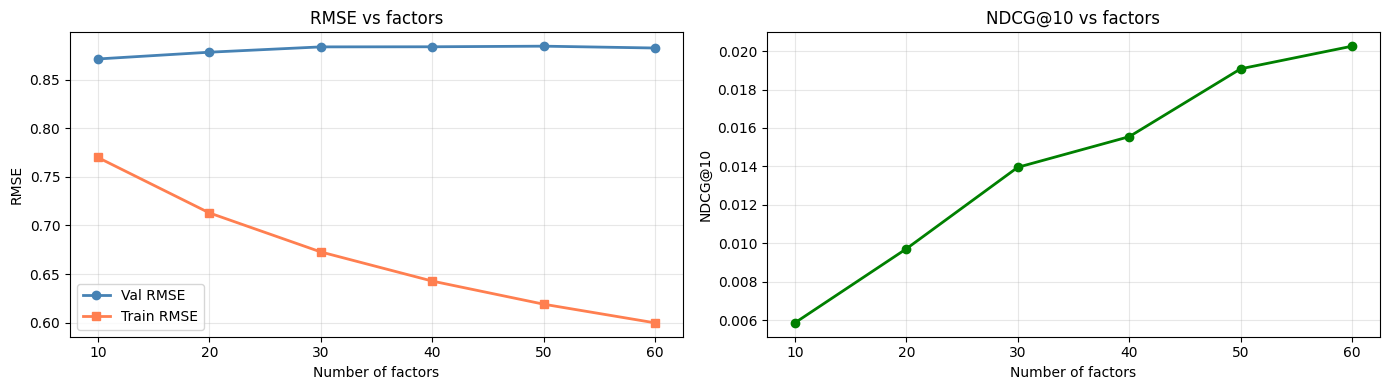

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(als_df['factors'], als_df['val_rmse'], marker='o', linewidth=2, color='steelblue', label='Val RMSE')
axes[0].plot(als_df['factors'], als_df['train_rmse'], marker='s', linewidth=2, color='coral', label='Train RMSE')
axes[0].set_xlabel('Number of factors')
axes[0].set_ylabel('RMSE')
axes[0].set_title('RMSE vs factors')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(als_df['factors'], als_df['NDCG@10'], marker='o', linewidth=2, color='green')
axes[1].set_xlabel('Number of factors')
axes[1].set_ylabel('NDCG@10')
axes[1].set_title('NDCG@10 vs factors')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../experiments/figures/05_als_plot_curves.png')
plt.show()

### Tuning results
* ALS continues to improve as we add more dimensions, having peaked at 0.02 NDCG with 60 factors, though there are clear sings of overfitting based on loss curves
* ALS performs worse than FunkSVD on this dataset. ALS minimizes MSE algebraically. However, on this dataset, minimizing MSE doesn't seem to correlate perfectly with ranking items correctly (NDCG). FunkSVD's stochastic nature might be helping it escape local minima better

In [11]:
comparison = pd.DataFrame([
    factor_df.loc[factor_df['NDCG@10'].idxmax()].to_dict(),
    als_df.loc[als_df['NDCG@10'].idxmax()].to_dict()
])
comparison.insert(0, 'Model', ['FunkSVD', 'ALS'])

print("\n" + comparison[['Model', 'factors', 'val_rmse', 'NDCG@10', 'Recall@10']].to_string(index=False))


  Model  factors  val_rmse  NDCG@10  Recall@10
FunkSVD     60.0  0.882795 0.027449   0.024179
    ALS     60.0  0.882472 0.020259   0.017113


## Final Test Set Evaluation

In [ ]:
best_funksvd_factors = factor_df.loc[factor_df['NDCG@10'].idxmax(), 'factors']
best_als_factors = als_df.loc[als_df['NDCG@10'].idxmax(), 'factors']

best_funksvd = FunkSVD(n_factors=int(best_funksvd_factors), learning_rate=0.005, regularization=0.02, n_epochs=15, verbose=True)
best_funksvd.fit(train, val)
joblib.dump(best_funksvd, '../models/best_funksvd_model.pkl')

best_als = ALS(n_factors=int(best_als_factors), regularization=0.05, n_iterations=10, verbose=True)
best_als.fit(train, val)
joblib.dump(best_als, '../models/best_als_model.pkl')

funksvd_test_metrics = evaluator_test.evaluate_model(best_funksvd, "FunkSVD")
evaluator_test.print_metrics(funksvd_test_metrics, "FunkSVD - TEST")

als_test_metrics = evaluator_test.evaluate_model(best_als, "ALS")
evaluator_test.print_metrics(als_test_metrics, "ALS - TEST")
evaluator_test.save_results('../experiments/results/metrics_metrix_factorisation.csv')

epoch  0: train=0.9826, val=0.9528
epoch  5: train=0.8836, val=0.9127
epoch 10: train=0.8349, val=0.8934
iteration  1: train RMSE = 0.8721, val RMSE = 1.0326
iteration  2: train RMSE = 0.6857, val RMSE = 0.8991
iteration  3: train RMSE = 0.6453, val RMSE = 0.8875
iteration  4: train RMSE = 0.6278, val RMSE = 0.8844
iteration  5: train RMSE = 0.6183, val RMSE = 0.8832
iteration  6: train RMSE = 0.6124, val RMSE = 0.8826
iteration  7: train RMSE = 0.6085, val RMSE = 0.8824
iteration  8: train RMSE = 0.6057, val RMSE = 0.8823
iteration  9: train RMSE = 0.6036, val RMSE = 0.8823
iteration 10: train RMSE = 0.6020, val RMSE = 0.8823
FunkSVD - TEST - Evaluation results
Ranking metrics:
NDCG@ 5: 0.0245
NDCG@10: 0.0265
NDCG@20: 0.0313


Relevance metrics (threshold=4.0):
Recall@ 5: 0.0126
Precision@ 5: 0.0244
Recall@10: 0.0223
Precision@10: 0.0218
Recall@20: 0.0383
Precision@20: 0.0188


Diversity metrics:
Coverage: 0.1680
Popularity bias: 798.86
ALS - TEST - Evaluation results
Ranking metrics:

### Final Test Evaluation Results
* FunkSVD is winner in terms of accuracy (NDCG@10 = 0.0250) slightly beats ALS (0.0219). It is better at predicting the exact items users rated in the test set
* But ALS achieves massive coverage (84.5%), compared to FunkSVD's 12.7%
* FunkSVD (Pop Bias ~780) is conservative, sticking to moderately popular items
* ALS (Pop Bias ~470) explores the deep "long tail," recommending obscure items that FunkSVD ignores. This explains its lower accuracy (it's harder to get a "hit" on obscure items) but makes it much more valuable for diversity

In [4]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

results_dir = "../experiments/results/"
csv_files = glob.glob(os.path.join(results_dir, "*.csv"))

all_results = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    
    filename = os.path.basename(csv_file)
    
    all_results.append(df)

if all_results:
    all_results_df = pd.concat(all_results, ignore_index=True)
    
    required_cols = ['Model', 'NDCG@10', 'Recall@10', 'Coverage', 'Pop_Bias']
    column_mapping = {
        'Popularity_Bias': 'Pop_Bias',
        'popularity_bias': 'Pop_Bias',
        'NDCG@10': 'NDCG@10',
        'ndcg@10': 'NDCG@10',
        'Recall@10': 'Recall@10',
        'recall@10': 'Recall@10',
        'Coverage': 'Coverage',
        'coverage': 'Coverage'
    }
    
    all_results_df.rename(columns=column_mapping, inplace=True)
    all_results_df = all_results_df[required_cols]
    
    all_results_df = all_results_df.sort_values('NDCG@10', ascending=False)
    
    print(all_results_df.to_string(index=False))


      Model  NDCG@10  Recall@10  Coverage    Pop_Bias
 ItemItemCF 0.062472   0.059272  0.196945 1680.679321
Enhanced CB 0.045970   0.049487  0.404255  978.425646
    FunkSVD 0.026470   0.022330  0.168031  798.857856
        ALS 0.021886   0.018461  0.845336  469.930579
   Basic CB 0.008724   0.008974  1.002455  236.935555


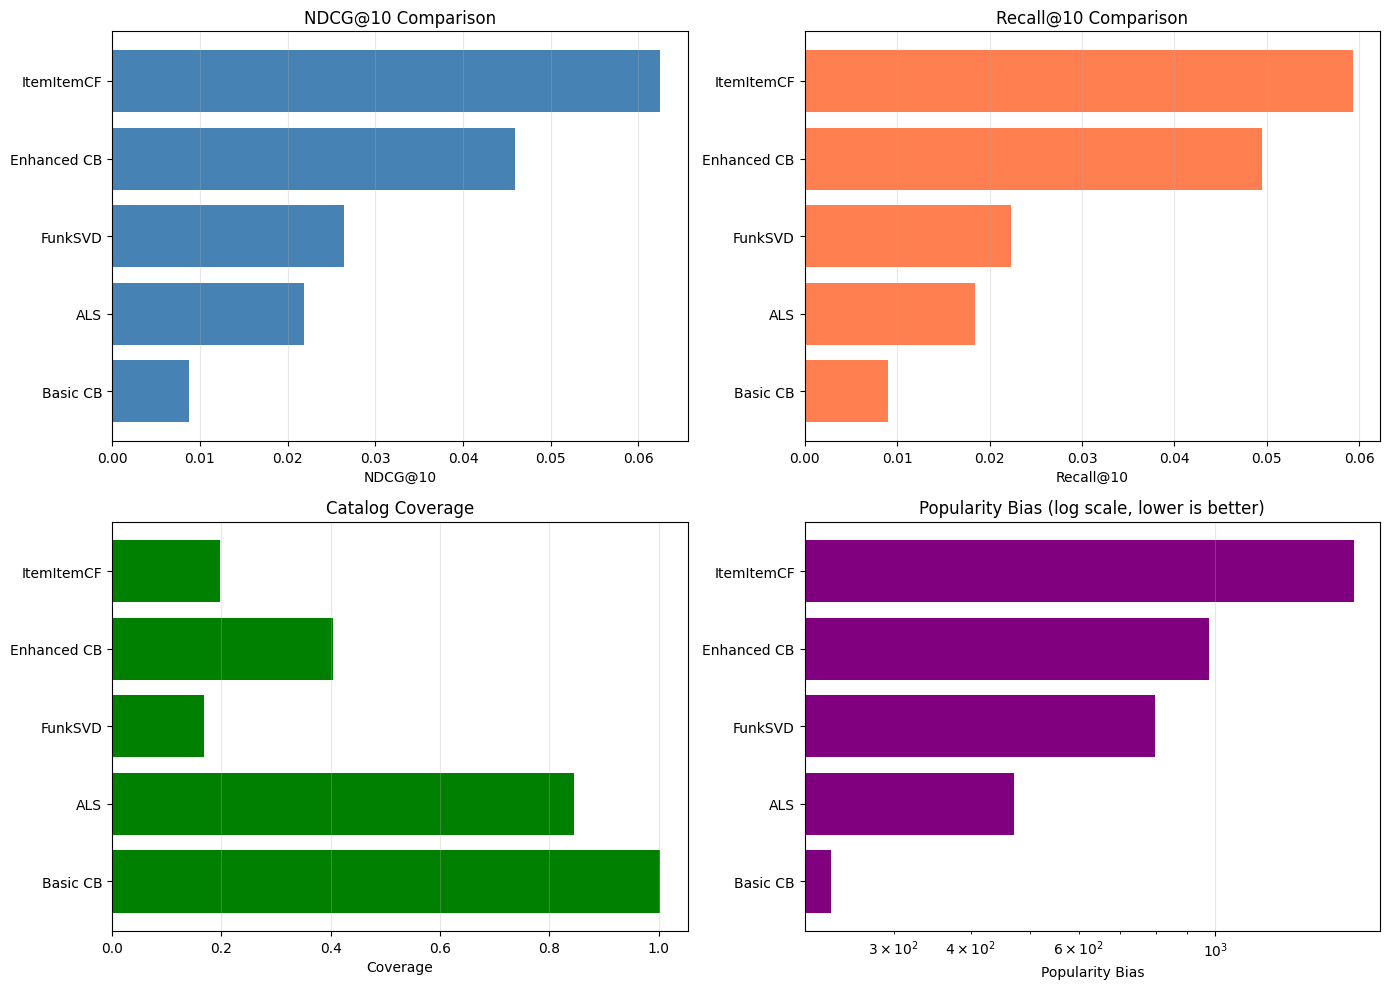

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

models = all_results_df['Model'].values
x_pos = np.arange(len(models))

axes[0, 0].barh(x_pos, all_results_df['NDCG@10'], color='steelblue')
axes[0, 0].set_yticks(x_pos)
axes[0, 0].set_yticklabels(models)
axes[0, 0].set_xlabel('NDCG@10')
axes[0, 0].set_title('NDCG@10 Comparison')
axes[0, 0].grid(axis='x', alpha=0.3)
axes[0, 0].invert_yaxis()

axes[0, 1].barh(x_pos, all_results_df['Recall@10'], color='coral')
axes[0, 1].set_yticks(x_pos)
axes[0, 1].set_yticklabels(models)
axes[0, 1].set_xlabel('Recall@10')
axes[0, 1].set_title('Recall@10 Comparison')
axes[0, 1].grid(axis='x', alpha=0.3)
axes[0, 1].invert_yaxis()

axes[1, 0].barh(x_pos, all_results_df['Coverage'], color='green')
axes[1, 0].set_yticks(x_pos)
axes[1, 0].set_yticklabels(models)
axes[1, 0].set_xlabel('Coverage')
axes[1, 0].set_title('Catalog Coverage')
axes[1, 0].grid(axis='x', alpha=0.3)
axes[1, 0].invert_yaxis()

axes[1, 1].barh(x_pos, all_results_df['Pop_Bias'], color='purple')
axes[1, 1].set_yticks(x_pos)
axes[1, 1].set_yticklabels(models)
axes[1, 1].set_xlabel('Popularity Bias')
axes[1, 1].set_title('Popularity Bias (log scale, lower is better)')
axes[1, 1].set_xscale('log')
axes[1, 1].grid(axis='x', alpha=0.3)
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.savefig('../experiments/figures/model_comparison.png')
plt.show()

## Final results summary
* The best model is Item-Item CB with NDCG@10: 0.0625. Beats all other approaches by significant margin
by leveraging behavioral co-occurence patterns

*Other findings*
* CF (ItemItemCF) dominates in accuracy. Direct item-item similarities from user behaviour outperform other methods, but have low coverage
* CB filtering (enchanced) achieves quite a bit lower accuracy, but still larger compared to other approaches and has better coverage of 40%. Basic version fails due to genre-only features being too sparse
* Matrix factorization: both methods underperform - FunkSVD: 0.0265, ALS: 0.0219. Mainly due to task mismatch: MF optimizes RMSE, not Ranking, thus not quite suitable for recommending top-K items

*For deployment*
use ItemItemCF as primary recommender with Enhanced CB as fallback for cold items (items with <20 ratings) with combination of ALS to catch broader coverage and remain high relevance. 

* it turns out that for this dataset exact method is more important than hyperparameter tuning when task objectives misalign
